In [1]:
import imageio
import numpy as np
import pandas as pd
from math import asin, cos, radians, sin, sqrt
from networkx import nx
import scipy as sp
from osgeo import gdal
from matplotlib.dates import DateFormatter
import contextily as cx
import geopandas
from PIL import Image
from sklearn import preprocessing
import cvxopt 
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
import cvxpy as cp
import seaborn as sns
import scipy as scipy
import matplotlib.pyplot as plt
%matplotlib inline
from pygsp import graphs
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform


In [2]:
CRS = "EPSG:4326"


STATION_LIST = [
    "ARZAL",
    "AURAY",
    "BELLE ILE-LE TALUT",
    "BIGNAN",
    "BREST-GUIPAVAS",
    "BRIGNOGAN",
    "DINARD",
    "GUERANDE",
    "ILE DE GROIX",
    "ILE-DE-BREHAT",
    "KERPERT",
    "LANDIVISIAU",
    "LANNAERO",
    "LANVEOC",
    "LORIENT-LANN BIHOUE",
    "LOUARGAT",
    "MERDRIGNAC",
    "NOIRMOUTIER EN",
    "OUESSANT-STIFF",
    "PLEUCADEUC",
    "PLEYBER-CHRIST SA",
    "PLOERMEL",
    "PLOUDALMEZEAU",
    "PLOUGUENAST",
    "PLOUMANAC'H",
    "POMMERIT-JAUDY",
    "PONTIVY",
    "PTE DE CHEMOULIN",
    "PTE DE PENMARCH",
    "PTE DU RAZ",
    "QUIMPER",
    "QUINTENIC",
    "ROSTRENEN",
    "SAINT-CAST-LE-G",
    "SARZEAU SA",
    "SIBIRIL S A",
    "SIZUN",
    "SPEZET",
    "ST BRIEUC",
    "ST NAZAIRE-MONTOIR",
    "ST-SEGAL S A",
    "THEIX",
    "VANNES-SENE",
]

In [3]:
class TFOG:
    def __init__(self, k, signal, graph, graph_size):
        
        self.k = k # order of delta
        self.signal = signal # input signal
        self.graph_size = graph_size # graph size(n*n)
        self.size = signal.size # signal size
        self.X = cp.Variable(shape=(self.size,)) # Variale type for solver (CVXOPT)
        self.g = graph #graph
        self.alpha = [] #
        self.cluster_edges_list = []

        
     
    # subfunction count nb of 1 (edges) in matrix
    def __count_one(self,x):
        tmp = 0
        for i in range(len(x)):
            for j in range(len(x)):
                if x[i][j] == 1:
                    tmp +=1
        return tmp
    # incidence to delta function
    def __inc_to_delta(self,inc):
        n = len(inc) 
        k = 0
       
        size = int(self.__count_one(inc)/2)
        tmp = [np.zeros(n) for i in range(size)]
        for i in range(n):
            # inc matrix is symetric
            for j in range(i,n):
                if inc[i][j] == 1:
                    tmp[k][i] = -1
                    tmp[k][j] = 1
                    k+=1

        return tmp
    
           
        
    # graph to inc matrix
    def inc_mat(self):
        W = self.g.W.toarray()
        tmp = np.zeros((len(W), len(W)))
        for i in range(len(W)):
            for j in range(len(W)):
                if W[i][j] !=0:
                    tmp[i][j] = 1
                    
        return tmp
    
    # graph difference order function : Dk+1 = D1^T @ Dk if odd k and Dk+1 = D1 @ Dk if even k (D0 makes no sens)
    def __GDO(self,delta, k):
        if k == 1:
            return delta
        elif k%2 == 0:
            return np.dot(np.transpose(delta), self.__GDO(delta, k-1))
        elif k%2 == 1:
            return np.dot(delta, self.__GDO(delta, k-1))
    # delta1 function
    def delta1(self):
        return self.__inc_to_delta(self.inc_mat())
        
    # deltak function
    def deltak(self):
        
        return np.array(self.__GDO(self.delta1(), self.k))
        
    

    # check if a list of list already contains another list
    def __in_list(x, L):
        tmp2 = False
        for y in L:
            tmp1 = True
            for i in range(len(x)):
                #avoid repetition 
                tmp1 = (tmp1 and np.abs(x[i]) == np.abs(y[i])) 
            tmp2 = (tmp2 or tmp1)
        return tmp2


    # plot the graph signal, can display edges with difference, the diff matrix may have some small data (1e-7 for example) instead of 0, accu is here to eliminate them
    def plot(self, show_border = True, accu = 1e1):
        if show_border:
            
            diff = np.dot(self.deltak(),self.X.value)
            
            color=[]    
            for i in range(len(diff)):

                if np.abs(diff[i]) < accu:
                    diff[i] = 0
                    color.append((0,0,0,0.1))
                else:
                    
                    color.append((1,0,0,1))
            self.g.plot_signal(self.signal, edge_color = color)
        else:    
            self.g.plot_signal(self.signal)
    
    # solve the pb using CVXOPT
    def solve(self, Verbose = False, vlambda = 50):
        
        X = cp.Variable(shape=(self.size,))
        obj = cp.Minimize(0.5 * cp.norm(self.signal - X,2)**2 
                  + vlambda * cp.norm(self.deltak()@X, 1) )
        prob = cp.Problem(obj)
        prob.solve(solver=cp.CVXOPT, verbose=Verbose)
        self.X = X
        
    # estimate diff matrix
    def diff(self):
        return self.deltak()@self.X.value
    
    
    
    
    def diff_for_edges_color(self):
        if self.k%2 == 1:
            self.alpha = self.diff()
            
        
        elif self.k%2 == 0:
            inc_m = self.inc_mat()
            mean_nodes = self.deltak()@self.X.value
            n = len(inc_m)
            tmp = []
            for i in range(n):
                # inc matrix is symetric
                for j in range(i,n):
                    if inc_m[i][j] == 1:
                        tmp.append(mean_nodes[i])
                        
            self.alpha = tmp
        
        return self.alpha
        
        
        
                        
                        
        
    
    
                
            
        
    
    # plot the noisy input, the output and the ouput with edge diff
    def summary(self, accu =1e1, vlambda = 50):
        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))
        
        self.solve(vlambda = vlambda)
        self.g.plot_signal(self.signal, ax = ax[0])
        cx.add_basemap(ax[0], crs=stations_gdf.crs.to_string(), zoom=8)
        
        ax[0].set_title("Noisy input")
        self.g.plot_signal(self.X.value,ax = ax[1],limits = [min(self.X.value), max(self.X.value)])
        cx.add_basemap(ax[1], crs=stations_gdf.crs.to_string(), zoom=8)
        diff = np.dot(self.deltak(),self.X.value)
        ax[1].set_title(f"Ouput k ={self.k - 1}" )
        color=[]    
        diff = self.diff_for_edges_color()
       # print(diff)
        for i in range(len(diff)):

            if np.abs(diff[i]) < accu:
                diff[i] = 0
                color.append((0,0,0,0.1))
            else:
                    
                color.append((1,0,0,1))
        
        self.g.plot_signal(self.X.value, edge_color = color, ax = ax[2], limits = [min(self.X.value), max(self.X.value)])
        cx.add_basemap(ax[2], crs=stations_gdf.crs.to_string(), zoom=8)
        ax[2].set_title("Difference edges colored Ouput")
       
        #self.g.plot_signal(self.X.value, edge_color = self.__edges_color_using_alpha(), ax = ax[3])
        print(self.k)
        
        #self.g.plot_signal(self.X.value,ax = ax[1], limits = [min(self.X.value), max(self.X.value)])
        
        
        
    
        plt.show()
    # Return the value of the solution
    def values(self):
        return self.X.value
    
    # genrealized  inverse function (extend to rectangular matrix)
    def __generalized_inverse(self, mat):
        return np.linalg.inv(np.transpose(mat) @ mat) @ np.transpose(mat)
    
    # estimate lambda max
    def lambda_max(self):
   
        lmda_max= 0.0
   
    
       
       
        lmda_max= np.linalg.norm(np.linalg.pinv(self.deltak() @ np.transpose(self.deltak()))@ self.deltak()@ self.signal, np.inf)
    
    
        return lmda_max
    #plot 3D representation of learned signal
    def plot_3d(self):
        fig =  plt.figure(figsize=(20,5))
        ax3d = plt.axes(projection='3d')
       
        
        ax3d.plot_trisurf(self.g.coords[:,0], self.g.coords[0:,1] ,self.X.value, cmap=plt.cm.Spectral)
       
        
    
        plt.show()
    #plot 3D representation of input signal  
    def plot_3d_signal(self):
        fig =  plt.figure(figsize=(20,5))
        ax3d = plt.axes(projection='3d')
        ax3d.plot_trisurf(self.g.coords[:,0], self.g.coords[0:,1] ,self.signal, cmap=plt.cm.Spectral)
        plt.show()
        
    # remove edges with high penality score to get all cluster on the graphs
    def to_cluster(self):
        self.diff_for_edges_color()
        mat = self.inc_mat()
       
        for i in range(len(self.alpha)):
            if np.abs(self.alpha[i]) >= 1e-4:
                
                s = self.deltak()[i].tolist().index(-1)
                e = self.deltak()[i].tolist().index(1)
                
                mat[e][s] = 0
                mat[s][e] = 0
        return mat
    
    
                
        
        

        
    
        
        
        
        
        
        
        
    
        
    
    
    


In [4]:
def my_plot(g, signal, edges_color,highlight = [], indices = False):
    ax = stations_gdf.geometry.plot(figsize=(15, 10))
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    g.plot_signal(signal, edge_color = edges_color, ax = ax, limits = [min(signal), max(signal)], highlight = highlight, indices = indices)


    
def count_one(x):
        tmp = 0
        for i in range(len(x)):
            for j in range(len(x)):
                if x[i][j] == 1:
                    tmp +=1
        return tmp
    
def inc_to_delta(inc):
        n = len(inc) 
        k = 0
        for i in range(n):
            for j in range(n):
                if inc[i][j] != 0:
                    inc[i][j] = 1
        size = int(count_one(inc)/2)
        tmp = [np.zeros(n) for i in range(size)]
        for i in range(n):
            # inc matrix is symetric
            for j in range(i,n):
                if inc[i][j] == 1:
                    tmp[k][i] = -1
                    tmp[k][j] = 1
                    k+=1

        return tmp    
    
    # graph difference order function : Dk+1 = D1^T @ Dk if odd k and Dk+1 = D1 @ Dk if even k (D0 makes no sens)
def GDO(delta, k):
        if k == 1:
            return delta
        elif k%2 == 0:
            return np.dot(np.transpose(delta), GDO(delta, k-1))
        elif k%2 == 1:
            return np.dot(delta, GDO(delta, k-1))
    
def get_delta1(adjacency_matrix):
        return inc_to_delta(adjacency_matrix)
        
    # deltak function
def get_deltak(delta1, k):
        
    return np.array(GDO(delta1,k))

def diff_for_edges_color(adjacency_matrix, deltak, beta, k):
        if k%2 == 1:
            alpha = deltak@beta
            
        
        elif k%2 == 0:
           
            mean_nodes = deltak@beta
            n = len(adjacency_matrix)
            tmp = []
            for i in range(n):
                # inc matrix is symetric
                for j in range(i,n):
                    if adjacency_matrix[i][j] == 1:
                        tmp.append(mean_nodes[i])
                        
            alpha = tmp
        
        return alpha                

In [5]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [6]:
def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

In [7]:
def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [9]:
data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

In [10]:

# only keep a subset of stations
keep_cond = stations_df.Nom.isin(STATION_LIST)
stations_df = stations_df[keep_cond]

keep_cond = data_df.station_name.isin(STATION_LIST)
data_df = data_df[keep_cond]

# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

stations_gdf.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude,geometry
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25,POINT (-3.00450 48.85517)
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281,POINT (-3.14767 48.40400)
2,22113006,LANNAERO,48.755333,-3.468667,173267,2433190,85,POINT (-3.46867 48.75533)
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148,POINT (-3.37683 48.55167)
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131,POINT (-2.41083 48.18267)


In [11]:
wind_velocity_df = data_df.pivot(
index = "date", values = "fxy", columns = "station_name"
)
wind_velocity_df.head()

station_name,ARZAL,AURAY,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,DINARD,GUERANDE,ILE DE GROIX,ILE-DE-BREHAT,...,SAINT-CAST-LE-G,SARZEAU SA,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,NaN,NaN,12.5,4.4,9.9,NaN,7.8,6.3,11.7,8.6,...,4.8,5.7,6.0,NaN,5.0,5.0,5.8,5.3,NaN,4.7
2014-01-01 01:00:00,NaN,NaN,12.9,3.7,9.9,NaN,6.2,7.0,11.7,5.4,...,4.3,6.3,6.0,NaN,6.0,6.9,6.2,5.3,NaN,5.2
2014-01-01 02:00:00,NaN,NaN,11.9,3.1,10.8,6.9,6.3,7.6,11.4,6.9,...,4.6,6.9,8.1,NaN,5.3,5.1,8.3,4.5,NaN,5.8
2014-01-01 03:00:00,NaN,NaN,12.7,3.9,9.5,8.1,6.4,6.7,12.1,7.9,...,6.4,6.0,9.2,NaN,7.3,5.4,6.3,4.8,NaN,4.7
2014-01-01 04:00:00,NaN,NaN,14.6,4.6,11.0,8.0,8.5,6.8,13.3,8.3,...,6.5,6.6,7.8,NaN,7.1,6.1,7.4,5.9,NaN,5.5


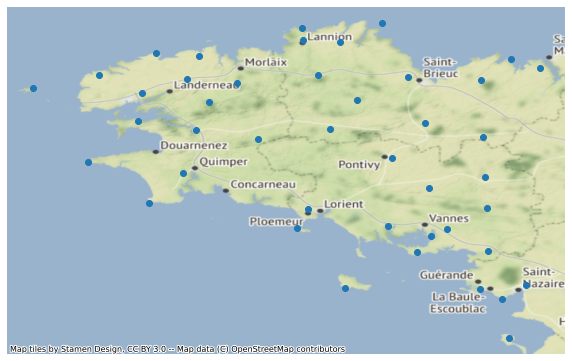

In [12]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

In [13]:
wind_velocity_df.isna().sum(axis=0).sort_values(ascending=False).head()

station_name
ARZAL         744
SIZUN         744
THEIX         744
ROSTRENEN     744
MERDRIGNAC    744
dtype: int64

In [14]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()

dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

In [15]:
threshold = 10  # km
adjacency_matrix = squareform((dist_mat_condensed < threshold).astype(int))
G = graphs.Graph(adjacency_matrix)

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=43, n_edges=2)'}>)

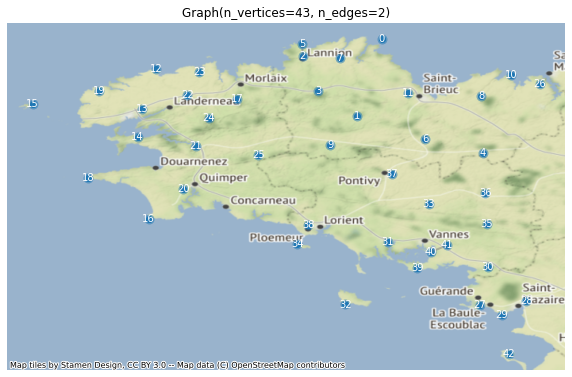

In [16]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot(ax=ax, indices = True)

In [17]:
sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = 0.85
adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)


(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=43, n_edges=105)'}>)

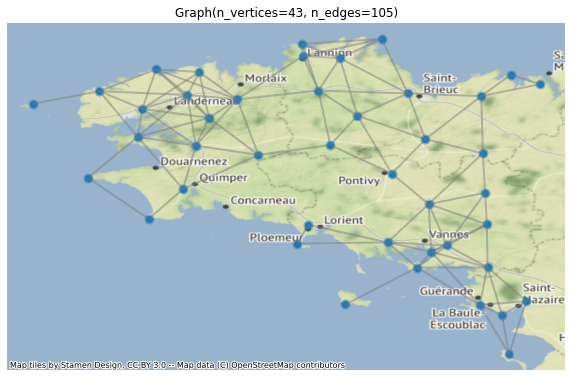

In [18]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

G_gaussian.set_coordinates(stations_np)
G_gaussian.plot(ax=ax)



In [19]:
wind_velocity_df.fillna(0, inplace = True)






signals = wind_velocity_df.to_numpy()
signal = wind_velocity_df.iloc[100].to_numpy()


nan = []
name = []

nan_adjacency_matrix_gaussian = adjacency_matrix_gaussian.copy()

nan_stations_gdf = stations_gdf.copy()
nan_stations_gdf.reset_index(drop=True, inplace=True)

nan_wind_velocity_df = wind_velocity_df.copy()




k = 0
for i in range(len(signal)):
    if signal[i] == 0.0:
        
        nan.append(i)
        name.append(nan_stations_gdf.iloc[i].Nom)
nan_signal= np.delete(signal, nan)
nan_adjacency_matrix_gaussian = np.delete(nan_adjacency_matrix_gaussian, nan, 0)
nan_adjacency_matrix_gaussian = np.delete(nan_adjacency_matrix_gaussian, nan, 1)
        
     
        
        
nan_stations_gdf.drop( nan ,axis = 0, inplace = True)

nan_wind_velocity_df.columns
nan_wind_velocity_df.drop(name, axis = 1, inplace=True)


        







34
34


(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=34, n_edges=67)'}>)

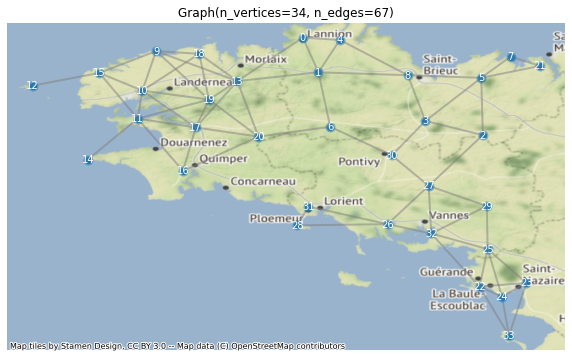

In [20]:
ax = nan_stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=nan_stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
nan_stations_np = nan_stations_gdf[["Longitude", "Latitude"]].to_numpy()
print(len(nan_stations_np))
print(len(nan_adjacency_matrix_gaussian))
G_nan = graphs.Graph(nan_adjacency_matrix_gaussian)
G_nan.set_coordinates(nan_stations_np)
G_nan.plot(ax=ax, indices =True)

In [21]:
size = len(nan_signal)
bzh_0 = TFOG(1,nan_signal, G_nan, size)
#bzh_1 = TFOG(2,signal, G_gaussian, size)
#bzh_2 = TFOG(3,signal, G_gaussian, size)
#bzh_3 = TFOG(4,signal, G_gaussian, size)

print(f'Lambda max for k = 0 : {bzh_0.lambda_max()}')

Lambda max for k = 0 : 3.575919957023917


1


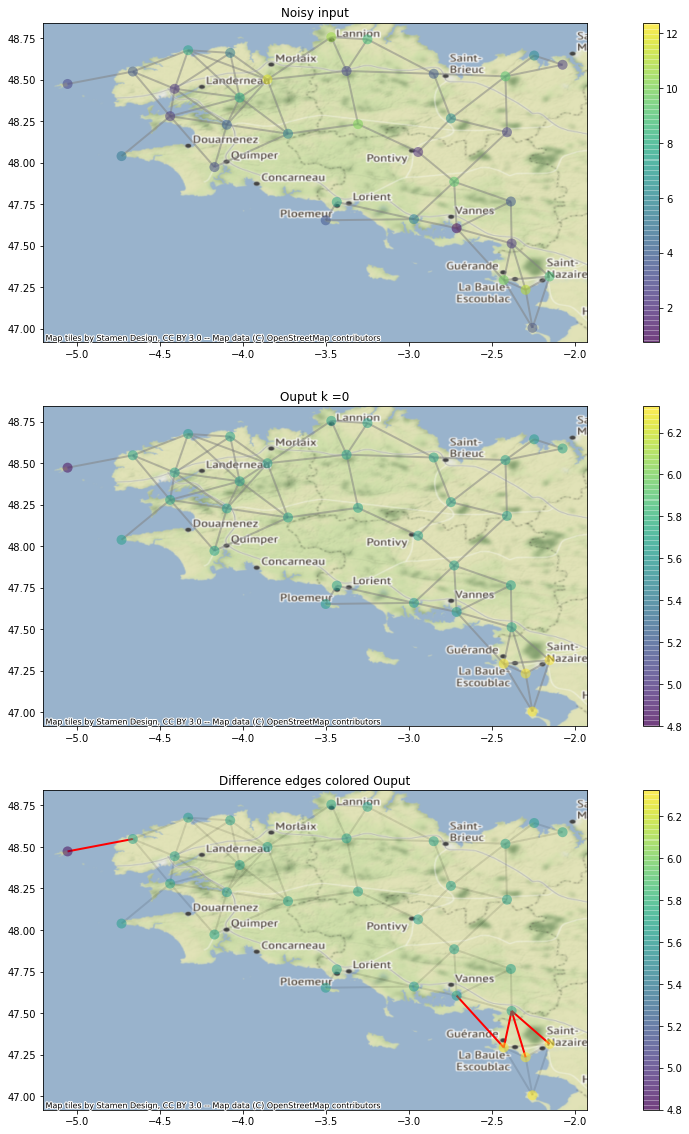

34

In [22]:
bzh_0.summary(vlambda=2, accu = 1e-4)
len(bzh_0.X.value)

In [33]:
nan_highlight = nan.copy()
res_values = bzh_0.X.value.copy().tolist()
for i in range(len(signal)):
    if signal[i] == 0.0:
        res_values.insert(i, 0.0)
print(res_values)
print('res_v', len(res_values))

print(len(signal))
print(nan)

while (0.0 in res_values):
    trig = False
    
    for n in nan:
        
        tmp = []
        for j in range(len(adjacency_matrix_gaussian)):
            
        
            if adjacency_matrix_gaussian[n][j] > 0.0 and j not in nan:
                #print(j,'is connected to n')
                trig = True
                tmp.append(res_values[j])
                
                
        if (trig == True):
            tmp = np.mean(tmp)
            res_values[n] = tmp
            nan.remove(n)
            trig = False
           
            break
            
       
        

print(res_values)
        
        
    
    

[0.0, 0.0, 5.655174295610552, 5.655171063854568, 5.6551707528178685, 0.0, 5.655170835141854, 5.655174209819353, 5.655170865098418, 5.6551711263942055, 5.655170794525614, 5.655170903903308, 5.655170549711745, 5.655170274307918, 5.6551701978630495, 4.799981735103943, 0.0, 5.655171016500765, 5.655170180197739, 5.655170128373856, 5.655170225371382, 5.6551703418897885, 0.0, 5.655170538978994, 5.655170536441581, 5.655170573085359, 5.655170602183669, 6.325015478436437, 6.325015498834687, 6.325015554249346, 5.655170930193307, 5.6551707805498515, 0.0, 5.655170809537234, 5.655170712620715, 5.655170754031037, 0.0, 5.655170737229971, 5.655170831183585, 0.0, 5.655170742124817, 0.0, 6.32501542383026]
res_v 43
43
[0, 1, 5, 16, 22, 32, 36, 39, 41]
[5.655173136444404, 5.655171479390543, 5.655174295610552, 5.655171063854568, 5.6551707528178685, 5.6551731764322195, 5.655170835141854, 5.655174209819353, 5.655170865098418, 5.6551711263942055, 5.655170794525614, 5.655170903903308, 5.655170549711745, 5.65517

[[-1.  0.  1. ...  0.  0.  0.]
 [-1.  0.  0. ...  0.  0.  0.]
 [-1.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  1.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]]
[ 1.15916615e-06  3.99878157e-08  1.07337495e-06 -2.23254110e-06
 -4.15535975e-07 -6.44248689e-07  2.73042881e-06 -3.52996338e-07
 -5.75487236e-07 -7.42160572e-07 -3.23175598e-06 -1.11917833e-06
 -8.57911990e-08 -3.27910979e-06  2.11257765e-06  3.14596478e-06
  6.25396375e-08 -1.59951260e-07 -4.73538027e-08  8.23239859e-08
  1.12280549e-07  5.67193652e-08  1.93108445e-08  1.03338713e-06
  2.99565635e-08  6.87614534e-08 -9.79118830e-08 -3.30591604e-06
 -7.05728036e-08  3.88048900e-08 -2.62914749e-07 -5.53308847e-07
 -3.89164234e-07 -1.92341945e-07 -2.75403827e-07  4.66789021e-07
 -4.21337889e-07 -1.01703282e-07 -1.07327507e-08 -1.32701636e-08
 -7.64448682e-08 -1.45934062e-07  6.75818708e-08  1.73700545e-07
  2.64671076e-07  2.62133663e-07 -1.76653101e-08 -6.94891940e-08
  2.75083325e-08  1.44026739

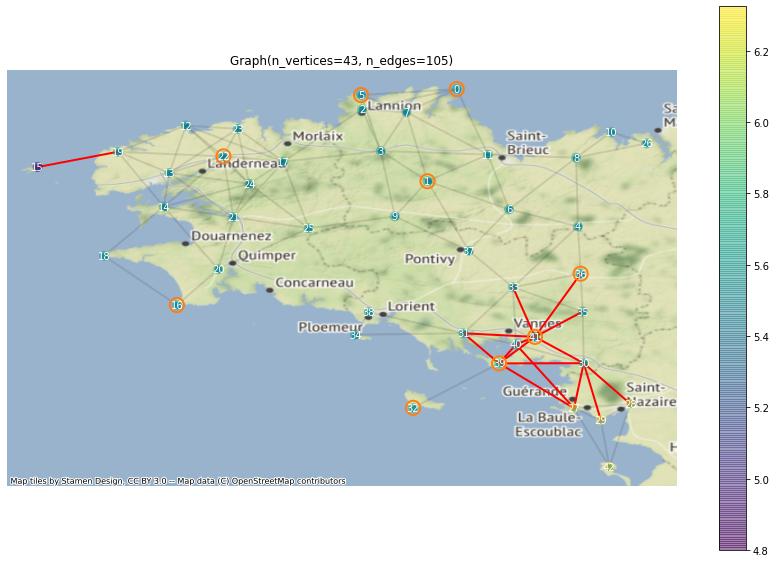

In [34]:

delta1 = get_delta1(adjacency_matrix_gaussian)

deltak = get_deltak(delta1, 1)
print(deltak)
alpha = diff_for_edges_color(adjacency_matrix_gaussian, deltak, res_values, 1)
print(alpha)
color = []
for i in range(len(alpha)):

            if np.abs(alpha[i]) < 1e-4:
                
                color.append((0,0,0,0.1))
            else:
                    
                color.append((1,0,0,1))
my_plot(G_gaussian, res_values, color,nan_highlight, indices = True)

(<Figure size 1080x720 with 2 Axes>,
 <AxesSubplot:title={'center':'Graph(n_vertices=43, n_edges=105)'}>)

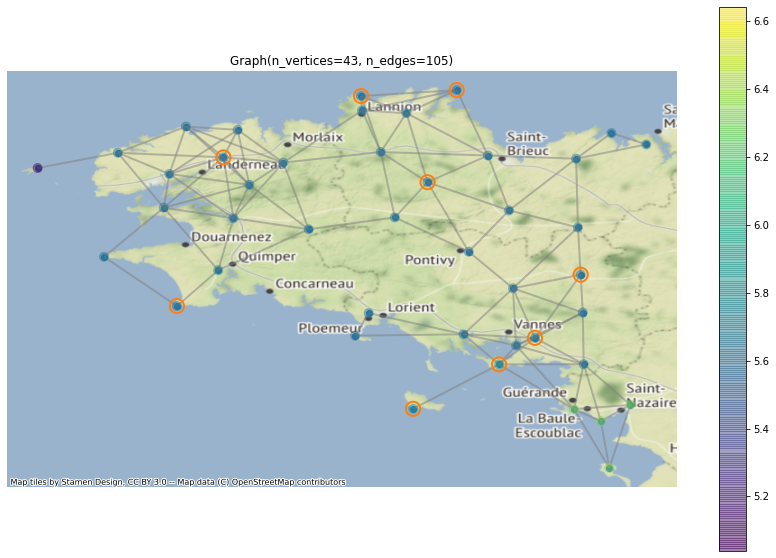

In [35]:
ax = stations_gdf.geometry.plot(figsize=(15, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.plot(res_values, ax=ax, highlight = nan_highlight)